<a href="https://colab.research.google.com/github/raulnusa98/learning-machine-learning/blob/main/PCA_manual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Drive

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Data_Science/SELF_TAUGHT/

Mounted at /content/drive
/content/drive/MyDrive/Data_Science/SELF_TAUGHT


# PCA from Scratch with NumPy

This notebook demonstrates how to implement Principal Component Analysis (PCA) step by step using NumPy and basic linear algebra tools.

We will:
- Explore the Iris dataset
- Center the data
- Calculate the covariance matrix
- Perform eigen decomposition manually
- Project the data onto the principal components
- Analyze the variance explained
- Compare our results with sklearn’s PCA implementation


## 1. Load and explore dataset
Even though the main objective of this notebook is to apply PCA, it is good practice to explore the dataset and pretend we don't know its nature. So first of all I will be doing little Exploratory Data Analysis (EDA).



In [2]:
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create data to practice
data = load_iris()
X = data.data
y = data.target
feature_names = data.feature_names
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

# Print data to check everything's fine
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


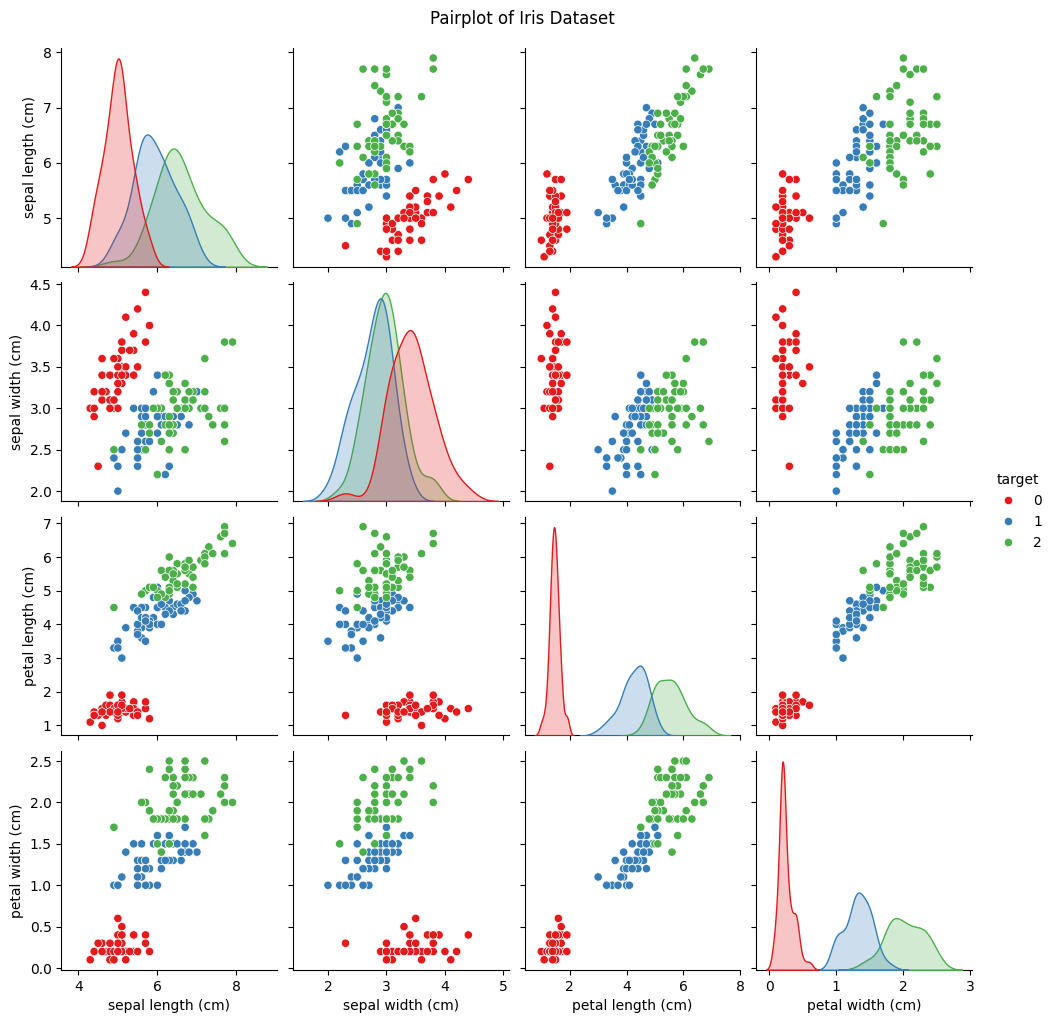

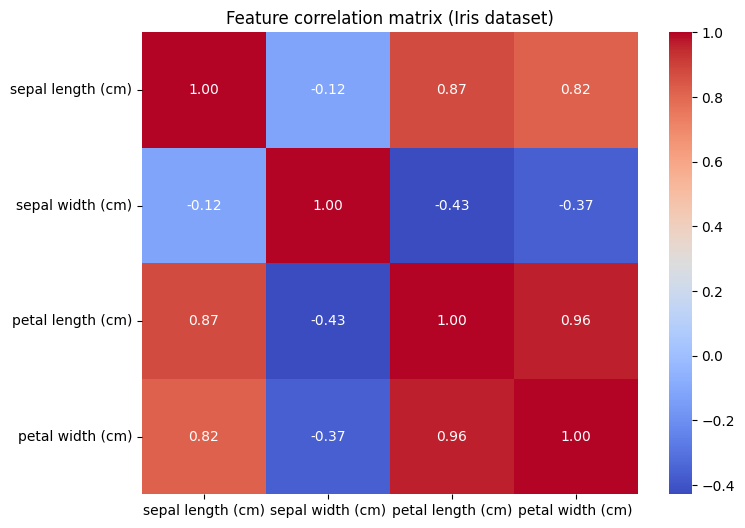

In [3]:
import seaborn as sns

# Pairplot to see predominant classes
sns.pairplot(df, hue='target', palette='Set1')
plt.suptitle('Pairplot of Iris Dataset', y=1.02)
plt.show()

# Correlation matrix
plt.figure(figsize=(8,6))
corr_matrix = df.iloc[:, :-1].corr() # All columns except target
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature correlation matrix (Iris dataset)')
plt.show()

In this pairplot, we can observe that the red class (Setosa) is clearly separated from the others. This is a strong indicator that PCA can be useful, because the technique relies on detecting directions in which the data varies the most across all features. When a class is well-separated in the original space, it means there is structure that PCA can capture and represent effectively in fewer dimensions.

# 2. Center data and calculate covariance matrix

First step of PCA is to center data. But what is center data? Imagine a 2D plane where each point is far from the others, but you need to get them closer to a point or line where the sum of all movements has to be the lowest. Bingo! Just get the mean of the variables and substract it to each of the variables.

Once we have the centered matrix, we multiply its transposed matrix by the original one to get the covariance matrix.

In [4]:
# Calculate and substract each column mean
X_centered = df.iloc[:, :-1] - df.iloc[:, :-1].mean()


# Create covariance matrix
X_centered_transposed = X_centered.T
cov_matrix = np.dot(X_centered_transposed, X_centered)

# Print out covariance matrix just in case
print(cov_matrix)

[[102.16833333  -6.32266667 189.873       76.92433333]
 [ -6.32266667  28.30693333 -49.1188     -18.12426667]
 [189.873      -49.1188     464.3254     193.0458    ]
 [ 76.92433333 -18.12426667 193.0458      86.56993333]]


# 3. Eigen Decomposition and variance visualization along different directions.

This is, in my opinion, the most important step in PCA. Eigenvalues are so important because they provide us the directions where the space doesn't change its nature. It either disperses or contracts itself. Now imagine we go to this point, in the direction of the eigenvector, far from the origin, where the points are so dispersed from eachother that we can reduce its dimensionality, and the points will only collapse. This way, we are reducing dimensions but keeping the essence of the variables.

Keep in mind that, datasets with more than 4 variable are very difficult to calculate and extract the roots of the polynomial. That's why we will be using np.linealg.eig, although it's possible to do it by multiplying lambda with identity matrix and substracting it to covariance matrix.

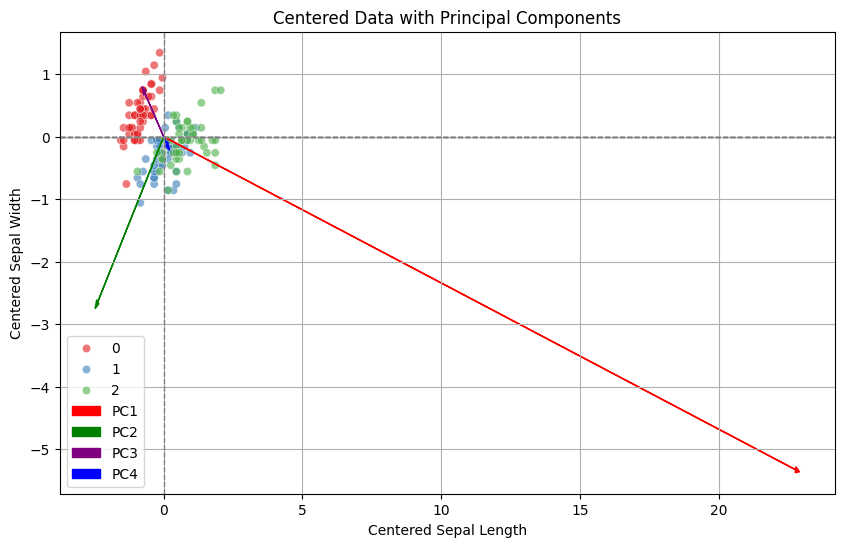

In [7]:
# Get eigenvalues and eigenvectors.
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

# Extract index of biggest eigenvalue
i_max = np.argmax(eig_vals)

# Extract principalm component belonging to i_max
principal_component = eig_vecs[:, i_max]

sorted_indices = np.argsort(eig_vals)[::-1]
eig_vals_sorted = eig_vals[sorted_indices]
eig_vecs_sorted = eig_vecs[:, sorted_indices]

# Convert X_centered to dataframe to be able to use iloc
X_centered_df = pd.DataFrame(X_centered, columns=feature_names)

# Visualize the two principal eigenvectors
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_centered_df.iloc[:, 0], y=X_centered_df.iloc[:, 1], hue=y, palette='Set1', alpha=0.6)

# Plot the arrows to be able to see visualy where the directions are pointing
colors = ['red', 'green', 'purple', 'blue'] # Set colors for each arrow


for i in range(4):
  vec = eig_vecs_sorted[:, i][:2] * eig_vals_sorted[i] * 0.1
  plt.arrow(0, 0, vec[0], vec[1], color=colors[i], width=0.005, head_width=0.1, label=f"PC{i+1}")
  plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.title("Centered Data with Principal Components")
plt.xlabel("Centered Sepal Length")
plt.ylabel("Centered Sepal Width")
plt.legend()
plt.grid(True)
plt.show()

## Plot conclusions

It's pretty clear there are directions that are able to explain variance of the data. For instance, we can see that the red arrow is the direction we should try and project all data, since we will be able to see data across a long line and preserve information. In fact, next step will be perfect to understand what I mean by new perspective and keep majority of information.

# 4. Project data onto Principal Components and Dimensionality reduction

Up until this point, we've shown how the data points are distributed with arbitrary axis. But PCA consists on changing the perspective of how we look into these points. We will transform the plane into a plane where X axis and Y axis are the two largest principal components (seen in the plot below as arrows; green and red).

Keep in mind, when we want to project the points into unitary vectors, we dont need to normalize the vectors. See the formula below:

### Vector projection formulas

The projection of a vector **v** onto a direction **u** is given by:

---

#### 1. General case (when **u** is *not* unitary):

$$
\text{proj}_{\mathbf{u}} \, \mathbf{v} = \left( \frac{\mathbf{v} \cdot \mathbf{u}}{\|\mathbf{u}\|^2} \right) \mathbf{u}
$$

---

#### 2. Simplified case (when **u** is a *unit vector*):

$$
\text{proj}_{\mathbf{u}} \, \mathbf{v} = (\mathbf{v} \cdot \mathbf{u}) \cdot \mathbf{u}
$$


In this case, as I was telling in the first paragraph, we will be using the second formula.




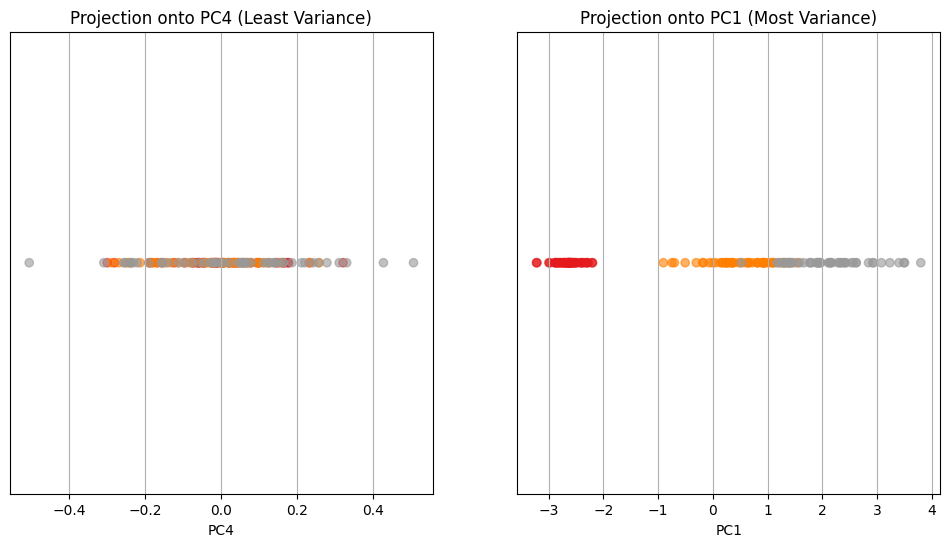

In [8]:
# We use the 2 largest eigenvectors as new axis
W = eig_vecs_sorted[:, :2]

# Choose eigenvectors with less variance and most variance. This way, we can
# visually understand what I've been explaining the whole notebook.

pc_min = eig_vecs_sorted[:, -1].reshape(-1, 1)
pc_max = eig_vecs_sorted[:, 0].reshape(-1, 1)

# Project all data onto pc_min and pc_max so we can compare
projected_data_min = np.dot(X_centered, pc_min)
projected_data_max = np.dot(X_centered, pc_max)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Projection into direction with less variance (we will see data points more crowded)
axes[0].scatter(projected_data_min, np.zeros_like(projected_data_min), c=y, cmap='Set1', alpha=0.6)
axes[0].set_title("Projection onto PC4 (Least Variance)")
axes[0].set_xlabel("PC4")
axes[0].set_yticks([])
axes[0].grid(True)

# Projection into direction with more variance (we will see data points more separated thus keep valuable information)
axes[1].scatter(projected_data_max, np.zeros_like(projected_data_max), c=y, cmap='Set1', alpha=0.6)
axes[1].set_title("Projection onto PC1 (Most Variance)")
axes[1].set_xlabel("PC1")
axes[1].set_yticks([])
axes[1].grid(True)

First think we need to notice is X axis. In PC1, data points are spread over 7 units, whereas PC4 is spread across 1 unit. In fact, red class (sepals) are not to be seen in PC4 mainly because there is no space.

# 5. Explained variance

Although PCA is not a supervised model (we're not making predictions), there are still valid ways to evaluate its effectiveness.

In this case, we can think of **eigenvectors** as the most relevant **orthogonal directions** in which the data varies. I emphasize *orthogonal* because, while there are infinitely many possible directions in space, PCA only considers those that are mutually perpendicular — which are the ones that truly matter when building a new coordinate system.

It makes sense, then, that there is **one eigenvector (and corresponding eigenvalue) for each original dimension** in the dataset. Since we had 4 original features, we obtain 4 eigenvectors and 4 eigenvalues, each pointing in a distinct orthogonal direction that helps explain the dataset's total variance.

By calculating the **ratio of each eigenvalue to the total**, we can understand **how much variance is preserved** by each principal component — and how much we retain when reducing dimensionality.


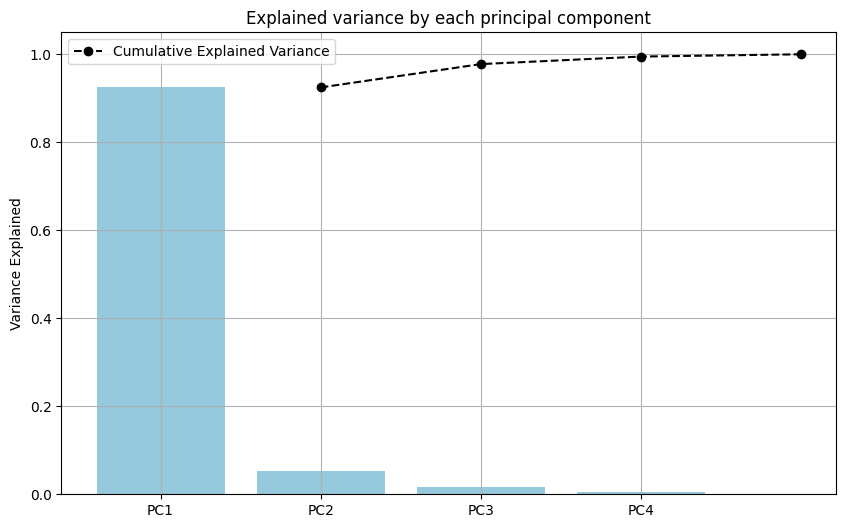

,Principal component,Explained variance ratio,Cumulative explained variance
0,PC1,0.924619,0.924619
1,PC2,0.053066,0.977685
2,PC3,0.017103,0.994788
3,PC4,0.005212,1.000000


In [9]:
# Calculate explained variance and cumulative
# This section will be developed with functions because the main intention is to compare results with sklearn library
def evaluate_pca(eig_vals):
  """
  Calculate explained variance and cumulative explained variance.
  Returns a DataFrame with results and plot.
  """
  # Descending order
  sorted_indices = np.argsort(eig_vals)[::-1]
  eig_vals_sorted = eig_vals[sorted_indices]

  # Ratios and cumulatives
  explained_variance_ratio = eig_vals_sorted / np.sum(eig_vals_sorted)
  explained_variance_cumsum = np.cumsum(explained_variance_ratio)

  # Visualization
  plt.figure(figsize=(10, 6))
  sns.barplot(x=[f'PC{i+1}' for i in range(len(eig_vals_sorted))],
              y=explained_variance_ratio, color='skyblue')
  plt.plot(np.arange(1, len(eig_vals_sorted)+1),
           explained_variance_cumsum, color='black', marker='o', linestyle='--', label='Cumulative Explained Variance')
  plt.ylim(0, 1.05)
  plt.ylabel("Variance Explained")
  plt.title("Explained variance by each principal component")
  plt.grid(True)
  plt.legend()
  # plt.tight_layout # Just in case
  plt.show()

  # Final DataFrame
  explained_df = pd.DataFrame({
      'Principal component': [f'PC{i+1}' for i in range(len(eig_vals_sorted))],
      'Explained variance ratio': explained_variance_ratio,
      'Cumulative explained variance': explained_variance_cumsum
  })
  return explained_df

explained_variance_manual_pca = evaluate_pca(eig_vals)
explained_variance_manual_pca

Notice that, by just keeping the two principal components, we preserve 97,76% of variance (cumulative). Good job!

Time to compare with sklearn library, although this is a beginner's dataset thus I expect similar results.

# 6. Compare results with sklearn.PCA

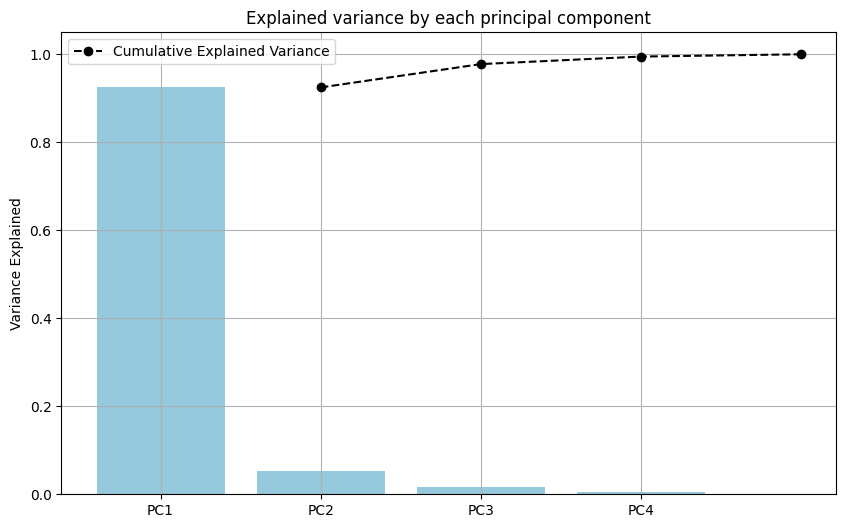

In [10]:
# This code cell is going to be very short, since I will be using sklearn

from sklearn.decomposition import PCA

# Apply PCA using centered data
pca_sklearn = PCA(n_components=4)
X_centered = pca_sklearn.fit_transform(X)

# Eigenvalues from sklearn
eigenvalues_sklearn = pca_sklearn.explained_variance_

# Explained variance ratio
explained_variance_ratio_sklearn = evaluate_pca(eigenvalues_sklearn)

# 7. Final thoughts

This notebook has helped me understand PCA from the inside out. I didn't cover basic topics and the essence of each matrix operations, such as dot products, determinants, etc, since I didn't want to make this notebook eternal and I don't think I would make such a good job as other good academic sources (Looking at you, 3Blue1Brown).

By manually computing each main step (centering the data, covariance, eigen decomposition and projection) I was able to visualize:

- Why PCA rotates the space
- How it chooses the directions that matters the most and where the data is most spread
- What it means to "preserve variance"
- How to reduce dimensions while keeping most if the information.

The final comparison with sklean.PCA confirmed that the manual implementation was mathematically correct, although I acknowledge the facility of this beginner's dataset, I feel satisfied over my results.

In the future, I would like to apply PCA on more complex datasets and combine it with clustering techniques or preprocessing before regression classification models.

This notebook is part of my learning portfolio, and I hope it helps others understand PCA in a more visually and simple way.